In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline
import matplotlib.cm as cm
import seaborn as sns
sns.set_style("dark")

from yellowbrick.cluster import KElbowVisualizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler

# Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture as EM

# Dim reduction
from sklearn.decomposition import PCA, FastICA, TruncatedSVD
from sklearn.random_projection import SparseRandomProjection, GaussianRandomProjection

# Models
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score

from sklearn.datasets import load_digits
from utils import learning_curve_plotter, model_param_curve, metrics

In [2]:
seed = 777

In [3]:
# Diabet Load Dataset

diabet_path = "./data/diabetes.csv"
df_diabet = pd.read_csv(diabet_path)

target = 'Outcome'
features = [ 'Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age']

X_origin, y = df_diabet[features], df_diabet[target]

# data normalize
sc = MinMaxScaler()
sc.fit(X_origin)

X = sc.transform(X_origin)
X_df = pd.DataFrame(X)
df_diabet = pd.concat([X_df, y], axis=1)

In [4]:
# Load Dataset

mnist = load_digits()

# fig, axes = plt.subplots(2, 10, figsize=(16, 6))
# for i in range(20):
#     axes[i//10, i %10].imshow(mnist.images[i], cmap='gray');
#     axes[i//10, i %10].axis('off')
#     axes[i//10, i %10].set_title(f"target: {mnist.target[i]}")
    
# plt.tight_layout()

# data normalize
sc = MinMaxScaler()
sc.fit(mnist.data)

X = sc.transform(mnist.data)
X_df = pd.DataFrame(X)
y_target = pd.DataFrame(mnist.target)
df_digit = pd.concat([X_df, y_target], axis=1)

# Clustering

## K-means Clustering

In [13]:
"""
https://m.blog.naver.com/slykid/221850725829
https://nicola-ml.tistory.com/6

shilhoutte analysis
각 군집 간의 거리가 얼마나 효율적으로 분리되어 있는지
-1~1사이의 값을 가지며 1에 가까울수록 좋다.
값이 높으면 객체가 자체 클러스터와 잘 일치, 클러스터와 잘 일치하지 않음.
"""

num_k = 15

def kmeans(df, num_k=15):
    sil_scores = []
    for k in range(2, num_k+1):
        kmeans = KMeans(n_clusters=k, n_init=10, random_state=seed).fit(df.iloc[:,:-1])
        sil_score = silhouette_score(df.iloc[:,:-1], kmeans.labels_)
        sil_scores.append(sil_score)
    
    return sil_scores

def silhouette_plotter(sil_scores, num_k, title_name=None):
    plt.title(title_name)
    plt.xlabel("num clusters")
    plt.ylabel("avg. silhouette score")
    plt.grid()
    plt.plot(list(range(2, num_k+1)), sil_scores, "-o", color="C1")
    plt.show()
    plt.close()

diabet_sil_scores = kmeans(df_diabet)
digit_sil_scores = kmeans(df_digit)

silhouette_plotter(diabet_sil_scores, num_k, title_name="Average shilhoute score for K-means")
silhouette_plotter(digit_sil_scores, num_k, title_name="Average shilhoute score for K-means")

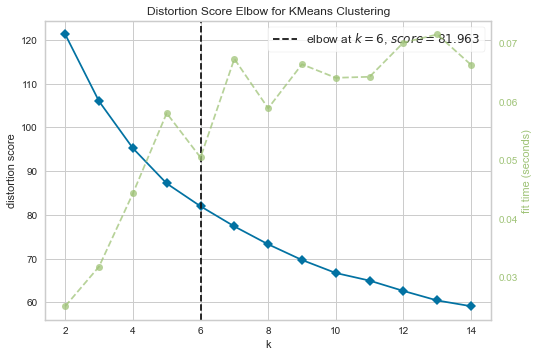

In [30]:
# 결과는 다음과 같이 나왔는데, 파란색이 각 데이터들의 군집 중심과의 평균 거리
# 초록색은 학습 시간을 나타낸다고 합니다.
# 검정색 점선의 위치를 보았을 떄, 여기서는 k = 4인 경우를 추천해주는 듯 합니다.
# 절대적인 정답이 있는 것은 아니니, 하나의 평가 지표로 활용하시면 좋을 듯 합니다.

def elbow_plotter(df_x, num_k):
    kmeans = KMeans()
    visualizer = KElbowVisualizer(kmeans, k=(2,num_k))
    visualizer.fit(df_x)
    visualizer.show()
    
elbow_plotter(df_diabet.iloc[:,:-1], num_k)
# elbow_plotter(df_digit.iloc[:,:-1], num_k)

In [31]:
def clustering_scores(optimal_k, df):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=seed).fit(df.iloc[:,:-1])
    prediction = kmeans.fit_predict(df_diabet.iloc[:,:-1])
    cluster_df = pd.DataFrame()
    cluster_df["kmeans_cluster"] = prediction
    cluster_df["target"] = df.iloc[:,-1]
    cluster_df = cluster_df.groupby(["target"])["kmeans_cluster"].value_counts()
    return cluster_df

# clustering_scores(8, df_digit)
clustering_scores(6, df_diabet)

target  kmeans_cluster
0       13                124
        7                  80
        4                  50
        8                  50
        3                  37
        5                  29
        9                  29
        0                  23
        12                 21
        10                 17
        2                  11
        11                 11
        1                   8
        6                   8
        14                  2
1       8                  34
        0                  33
        12                 32
        1                  30
        5                  25
        7                  18
        10                 16
        11                 16
        6                  15
        9                  15
        3                  13
        4                  12
        14                  6
        13                  2
        2                   1
Name: kmeans_cluster, dtype: int64

In [7]:
# pca = PCA(random_state=seed, n_components=dim)
# X_pca = pca.fit_transform(df_digit.iloc[:,:-1])

# # pca.explained_variance_ratio_

# X_pca = pd.DataFrame(X_pca, columns=["x", "y"])
# target = pd.DataFrame(df_digit.iloc[:,-1]).reset_index(drop=True)
# merged = pd.concat([X_pca, target], axis=1)

# # markers=['^', 's', 'o']

# # plt.figure(figsize=(16, 9))
# # plt.grid()

# # markers=['s', 'o']
# # for i, marker in enumerate(markers):
# #     x_axis_data = merged[merged['0']==i]['x']
# #     y_axis_data = merged[merged['0']==i]['y']
# #     plt.scatter(x_axis_data, y_axis_data, marker=marker, label=i, s=30)

# # plt.legend()
# # plt.show()

# nn_clf = MLPClassifier(random_state=seed, max_iter=1000, early_stopping=False, activation="tanh")
# scores = cross_val_score(nn_clf, X_pca, df_digit.iloc[:,-1], scoring="accuracy", cv=3)
# print(np.mean(scores))

NameError: name 'dim' is not defined

## EM algorithm

- 가우시안 분포: 도수 분포 곡선이 평균값을 중심으로 좌우 대칭
- GMM (Gaussian Mixture Model): 군집화에 대한 데이터가 여러개의 가우시안 분포를 가진 데이터 집합들이 섞여서 생성된 것이라는 가정
- GMM에서 모수추정을 위해 2가지 추정방법: 개별 정규 분포의 평균과 분산 / 각 데이터가 어떤 정규 분포에 해당하는지의 확률

In [ ]:
sil_scores = []
aic_scores = []
bic_scores = []

for k in range(2, num_k+1):
    em = EM(n_components=2, warm_start=True, random_state=seed).fit(df_diabet.iloc[:,:-1])
    pred = em.predict(df_diabet.iloc[:,:-1])
    sil_score = silhouette_score(df_diabet.iloc[:,:-1], pred)
    sil_scores.append(sil_score)
    aic_scores.append(em.aic(df_diabet.iloc[:,:-1]))
    bic_scores.append(em.bic(df_diabet.iloc[:,:-1]))

In [ ]:
test_df = pd.DataFrame()
test_df["gmm_cluster"] = pred
test_df["target"] = df_diabet.iloc[:,-1]

test_result = test_df.groupby(["target"])["gmm_cluster"].value_counts()

In [ ]:
plt.plot(list(range(2, num_k+1)), sil_scores, "-o", color="C2")
# plt.plot(list(range(2, num_k+1)), aic_scores, "-o", color="C5")
# plt.plot(list(range(2, num_k+1)), bic_scores, "-o", color="C7")
plt.grid()
plt.show()

# Dimensionality Reduction

In [ ]:
# Clustering 시각화 → DR 진행 → DR + Clustering → DR + NN (Assign #1) → DR + Clustering + NN
# https://wjddyd66.github.io/handson/Ch8.Dimensionality_Reduction/

dim = 2

# best parameter tester
best_nn_clf = MLPClassifier(
    random_state=seed,
    hidden_layer_sizes=30,
    learning_rate_init=0.1,
    max_iter=40
)

best_nn_clf.fit(df_diabet.iloc[:,:-1], df_diabet.iloc[:,-1])

## PCA

In [ ]:
pca = PCA(random_state=seed, n_components=dim)
X_pca = pca.fit_transform(df_diabet.iloc[:,:-1])

# pca.explained_variance_ratio_

X_pca = pd.DataFrame(X_pca, columns=["x", "y"])
target = pd.DataFrame(df_diabet.iloc[:,-1]).reset_index(drop=True)
merged = pd.concat([X_pca, target], axis=1)

# markers=['^', 's', 'o']

plt.figure(figsize=(16, 9))
plt.grid()

markers=['s', 'o']
for i, marker in enumerate(markers):
    x_axis_data = merged[merged['Outcome']==i]['x']
    y_axis_data = merged[merged['Outcome']==i]['y']
    plt.scatter(x_axis_data, y_axis_data, marker=marker, label=i, s=30)

plt.legend()
plt.show()

nn_clf = MLPClassifier(random_state=seed, max_iter=1000, early_stopping=False, activation="tanh")
scores = cross_val_score(nn_clf, df_diabet.iloc[:,:-1], df_diabet.iloc[:,-1], scoring="accuracy", cv=3)
print(np.mean(scores))

In [ ]:
# markers=['^', 's', 'o']

plt.figure(figsize=(16, 9))
plt.grid()

markers=['s', 'o']
for i, marker in enumerate(markers):
    x_axis_data = merged[merged['Outcome']==i]['x']
    y_axis_data = merged[merged['Outcome']==i]['y']
    plt.scatter(x_axis_data, y_axis_data, marker=marker, label=i, s=30)

plt.legend()
plt.show()

In [ ]:
nn_clf = MLPClassifier(random_state=seed, max_iter=1000, early_stopping=False, activation="tanh")
scores = cross_val_score(nn_clf, df_diabet.iloc[:,:-1], df_diabet.iloc[:,-1], scoring="accuracy", cv=3)
print(np.mean(scores))

In [ ]:
scores_pca = cross_val_score(nn_clf, X_pca, df_diabet.iloc[:,-1], scoring="accuracy", cv=3)
print(np.mean(scores_pca))

## ICA

In [ ]:
ica = FastICA(random_state=seed, n_components=dim)
X_ica = ica.fit_transform(df_diabet.iloc[:,:-1])
X_ica = pd.DataFrame(X_ica, columns=["x", "y"])
target = pd.DataFrame(df_diabet.iloc[:,-1]).reset_index(drop=True)
merged = pd.concat([X_ica, target], axis=1)

In [ ]:
plt.figure(figsize=(16, 9))
plt.grid()

markers=['s', 'o']
for i, marker in enumerate(markers):
    x_axis_data = merged[merged['Outcome']==i]['x']
    y_axis_data = merged[merged['Outcome']==i]['y']
    plt.scatter(x_axis_data, y_axis_data, marker=marker, label=i, s=30)

plt.legend()
plt.show()

In [ ]:
scores_pca = cross_val_score(nn_clf, X_ica, df_diabet.iloc[:,-1], scoring="accuracy", cv=3)
print(np.mean(scores_pca))

## Randomized Projections

In [ ]:
rp = SparseRandomProjection(random_state=seed, n_components=dim)
X_rp = rp.fit_transform(df_diabet.iloc[:,:-1])
X_rp = pd.DataFrame(X_rp, columns=["x", "y"])
target = pd.DataFrame(df_diabet.iloc[:,-1]).reset_index(drop=True)
merged = pd.concat([X_rp, target], axis=1)

In [ ]:
plt.figure(figsize=(16, 9))
plt.grid()

markers=['s', 'o']
for i, marker in enumerate(markers):
    x_axis_data = merged[merged['Outcome']==i]['x']
    y_axis_data = merged[merged['Outcome']==i]['y']
    plt.scatter(x_axis_data, y_axis_data, marker=marker, label=i, s=20)

plt.legend()
plt.show()

In [ ]:
scores_rp = cross_val_score(nn_clf, X_rp, df_diabet.iloc[:,-1], scoring="accuracy", cv=3)
print(np.mean(scores_rp))

# Truncated SVD

In [ ]:
svd = TruncatedSVD(n_components=2, random_state=seed)
# X_svd = svd.fit(df_diabet.iloc[:,:-1])
X_svd = svd.fit_transform(df_diabet.iloc[:,:-1])
X_svd = pd.DataFrame(X_svd, columns=["x", "y"])

merged = pd.concat([X_svd, target], axis=1)

# target = pd.DataFrame(df_diabet.iloc[:,-1]).reset_index(drop=True)
# merged = pd.concat([X_lda, target], axis=1)

plt.figure(figsize=(16, 9))
plt.grid()

markers=['s', 'o']
for i, marker in enumerate(markers):
    x_axis_data = merged[merged['Outcome']==i]['x']
    y_axis_data = merged[merged['Outcome']==i]['y']
    plt.scatter(x_axis_data, y_axis_data, marker=marker, label=i, s=20)

plt.legend()
plt.show()

In [ ]:
scores_svd = cross_val_score(nn_clf, X_svd, df_diabet.iloc[:,-1], scoring="accuracy", cv=3)
print(np.mean(scores_lda))

In [ ]:
# https://github.com/srpatel625/cs7641-assignment3